# Working with SPL Data

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [2]:
plt.rcParams['figure.figsize'] = 15, 8
plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

## Loading from CSV
Sound Pressure Level data ($L_{Aeq}$) contains two weeks of data, pulled from the SONYC node at 719 Broadway.

In [6]:
# reading in, with dates, and setting index so it's useful
df_full = pd.read_csv('spl_data.csv', parse_dates=['level_time']).set_index('level_time')

# printing the data span
print('data spanning: {:%m/%d/%Y %H:%M:%S} - {:%m/%d/%Y %H:%M:%S}'.format(
    df_full.index.min(), df_full.index.max()
))

df_full.head()
# time stamp and dB data
# we're going to use LAEQ = weighted based on what we understand and hear
# (lzeq = unweighted)
# at sensor edge we've taken raw samples and converted into dB

data spanning: 02/13/2018 14:06:19 - 02/27/2018 14:06:12


,laeq,lceq,lzeq
level_time,,,
2018-02-13 14:06:19.030,78.33,92.23,93.74
2018-02-13 14:06:24.030,78.17,93.08,95.05
2018-02-13 14:06:28.030,78.83,93.69,95.67
2018-02-13 14:06:32.030,78.41,95.91,97.80
2018-02-13 14:06:35.030,80.48,94.70,96.72


## What does it look like?
Let's take a look at the raw SPL data from the node. We are going to take a smaller subsample of the data because plotting the full dataset takes a really long time.

In [4]:
# give us 24 hours worth of data to play with
df = df_full['2018/02/14 00:00:00':'2018/02/15 00:00:00'] # let's look at a smaller sample

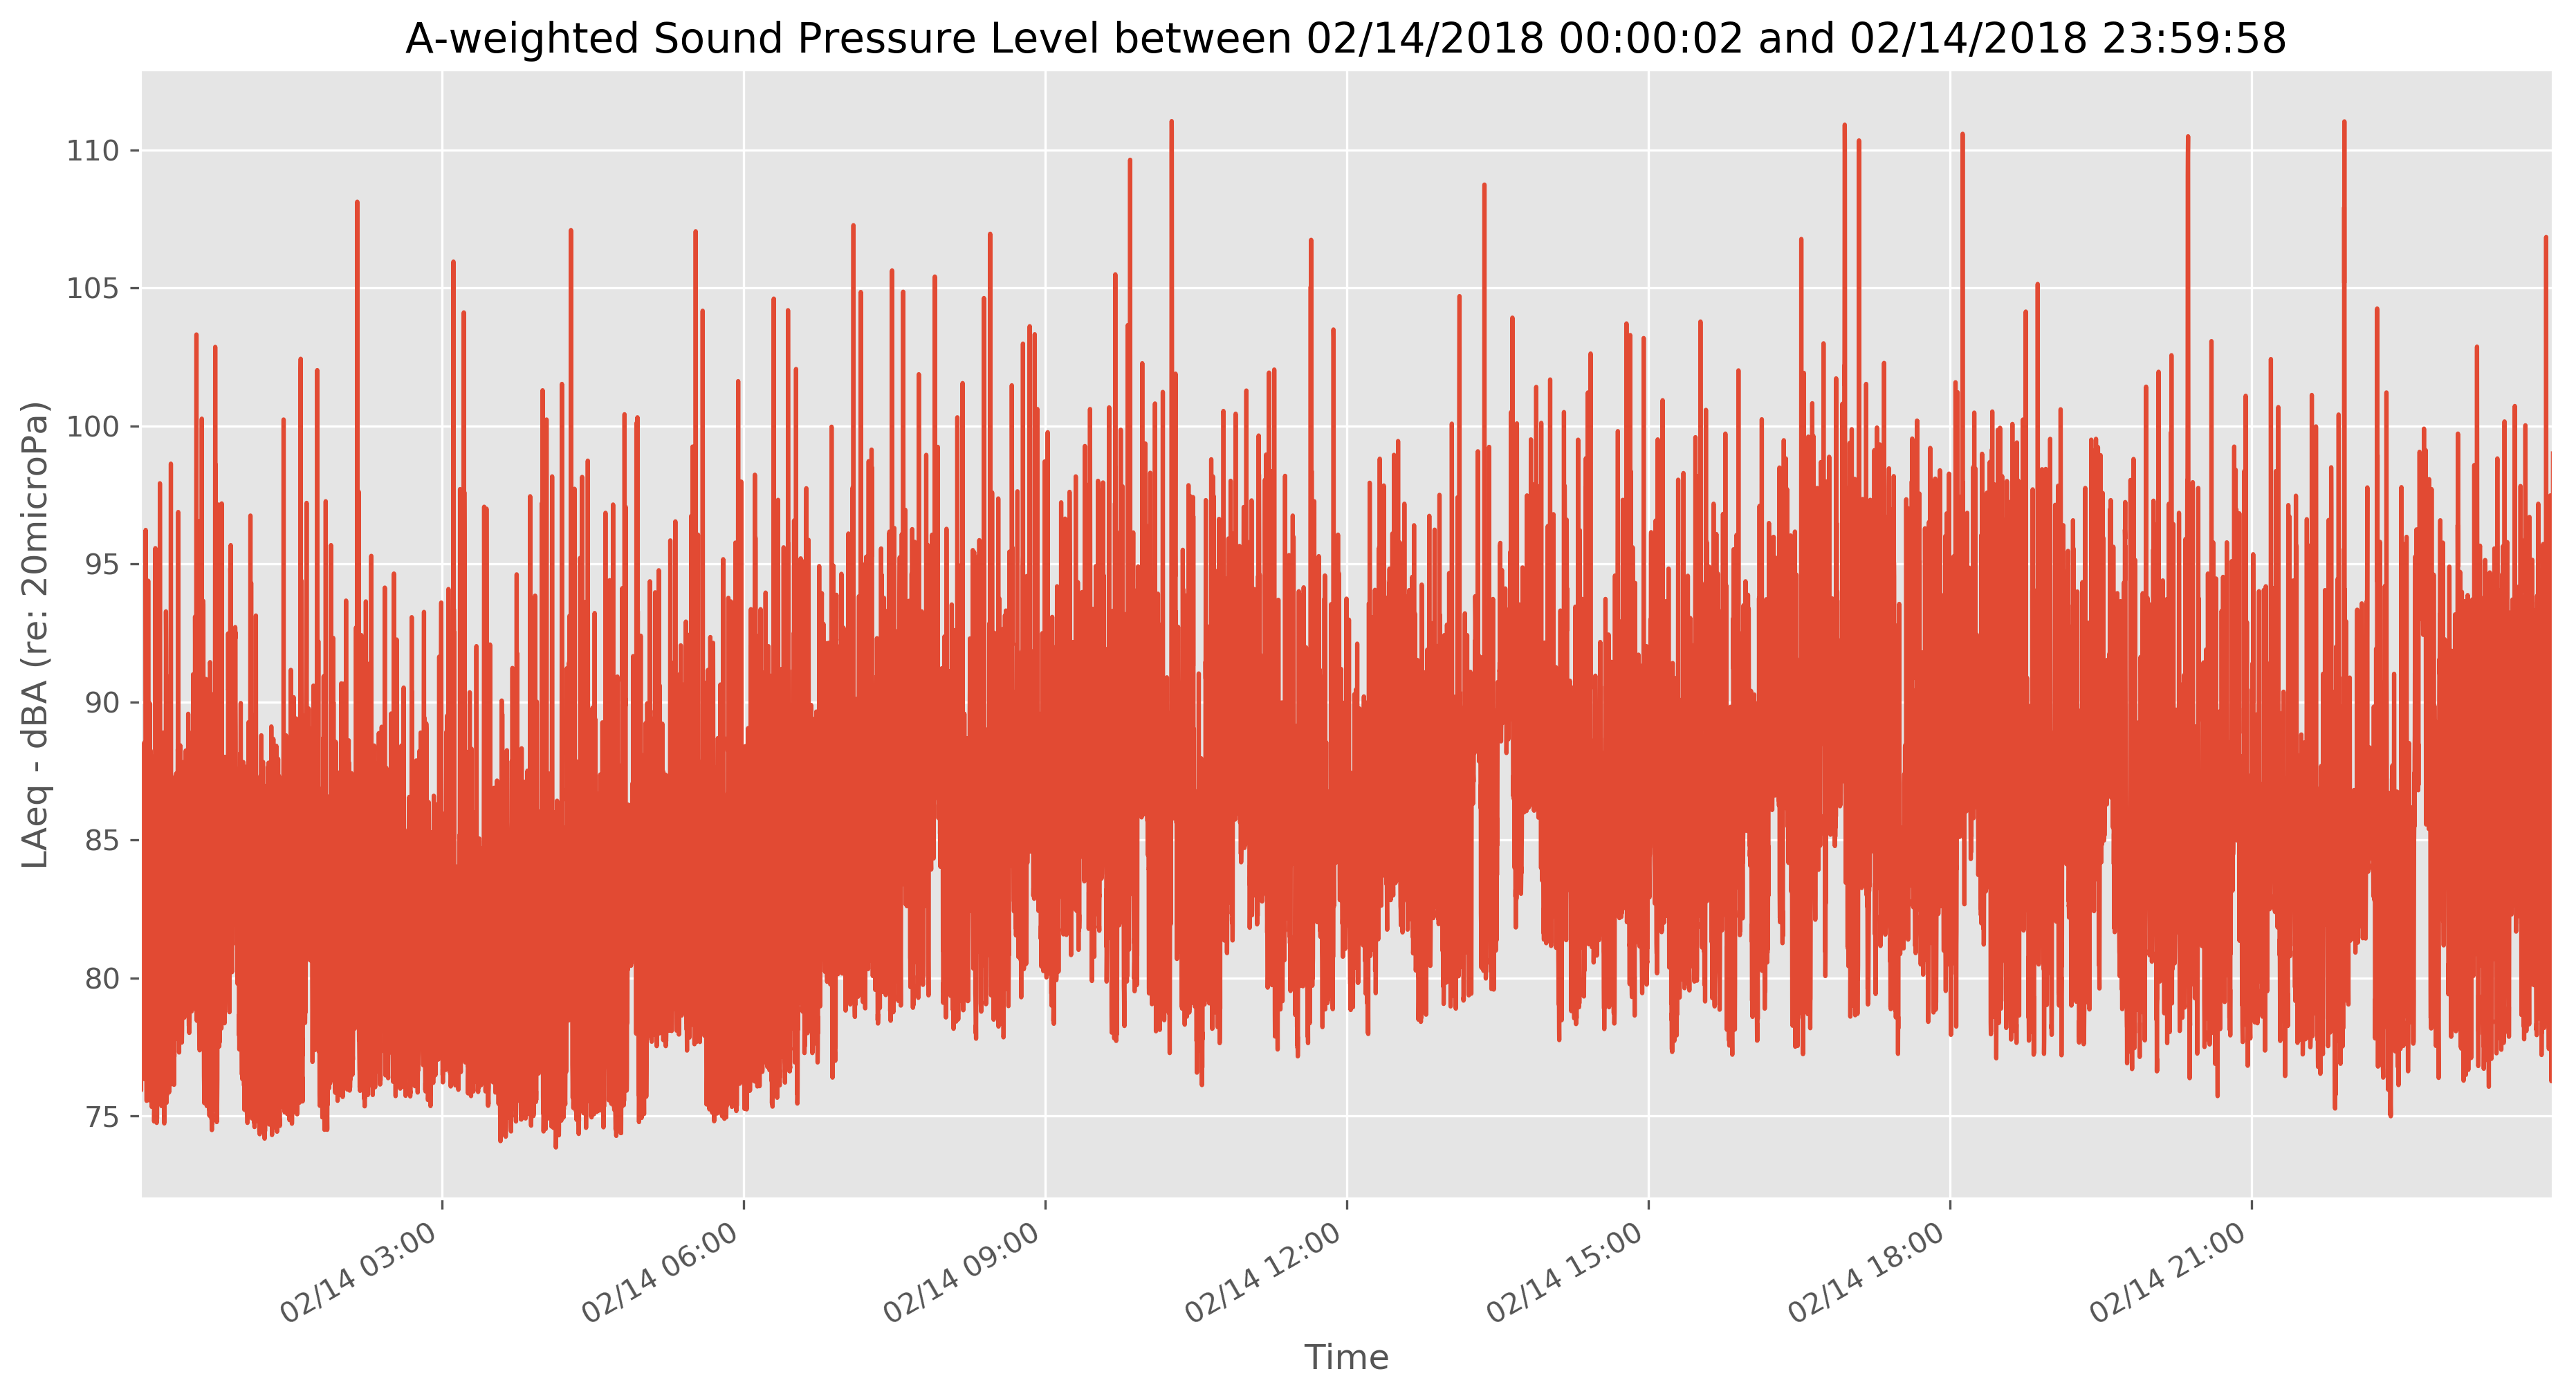

In [5]:
df.laeq.plot()
plt.title('A-weighted Sound Pressure Level between {:%m/%d/%Y %H:%M:%S} and {:%m/%d/%Y %H:%M:%S}'.format(
    df.index.min(), df.index.max()
))
plt.xlabel('Time')
plt.ylabel('LAeq - dBA (re: 20microPa)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%m/%d %H:%M'));

Well that's a mess. Let's do some averaging.

## dB Averaging
Sound pressure levels are represented using decibels (dB), which is a logarithmic unit meant to represent the relationship between two values. With sound, we are looking at the ratio between a pressure reading against some reference pressure. In most cases, the reference pressure used is the threshold of human hearing ($20\mu Pa)$. The equation for calculating decibels can be seen below.

$$dB=10log(P^2/P_0^2)$$

So when we want to find the average sound pressure level, we need to take an average of the squared pressure (a.k.a. power) measurements. This involves backing out from dB to pressure, averaging the pressure values, and converting back to decibels.

$$\frac{P^2}{P_0^2} = 10^{dB/10}$$
$$dB_{mean}=10log\left(mean\left(\frac{P^2}{P_0^2}\right)\right)$$


In [8]:
# you can't just take a np.mean on this because it's log value

def mean_dB(dBs):
    '''Takes the average of a series of sound level measurements.
    This is done by averaging the arguments of the log function in the dB equation.
        where: dB = 10*log10(argument)
        then: dB_avg = 10*log10(mean(arguments))
    Arguments:
        dBs (Series/np.array): an array of SPL measurements
    Returns:
        average dB (float)
    '''
    return 10*np.log10( np.mean(10**(dBs / 10.)) )

dBs = np.array([60, 65, 55, 40, 68, 78, 77, 90])

print(dBs)
# normal mean doesn't tell you anything - you can't use regular rolling means/windows
print('Algorithmic Mean: {:.1f} dB'.format(np.mean(dBs)))
# log mean is much higher - these are significantly different
print('Logarithmic Mean: {:.1f} dB'.format(mean_dB(dBs)))

[60 65 55 40 68 78 77 90]
Algorithmic Mean: 66.6 dB
Logarithmic Mean: 81.5 dB


Now we can use this function to take a rolling average over the entire signal using a window size that we specify. Using `average_over`, you can specify the length of the window in minutes. We then multiply that by the average number of samples per minute to get the window size.

rolling average over 120 minutes, ~14.7 samples / min
this makes sense for a weekday - check these trends


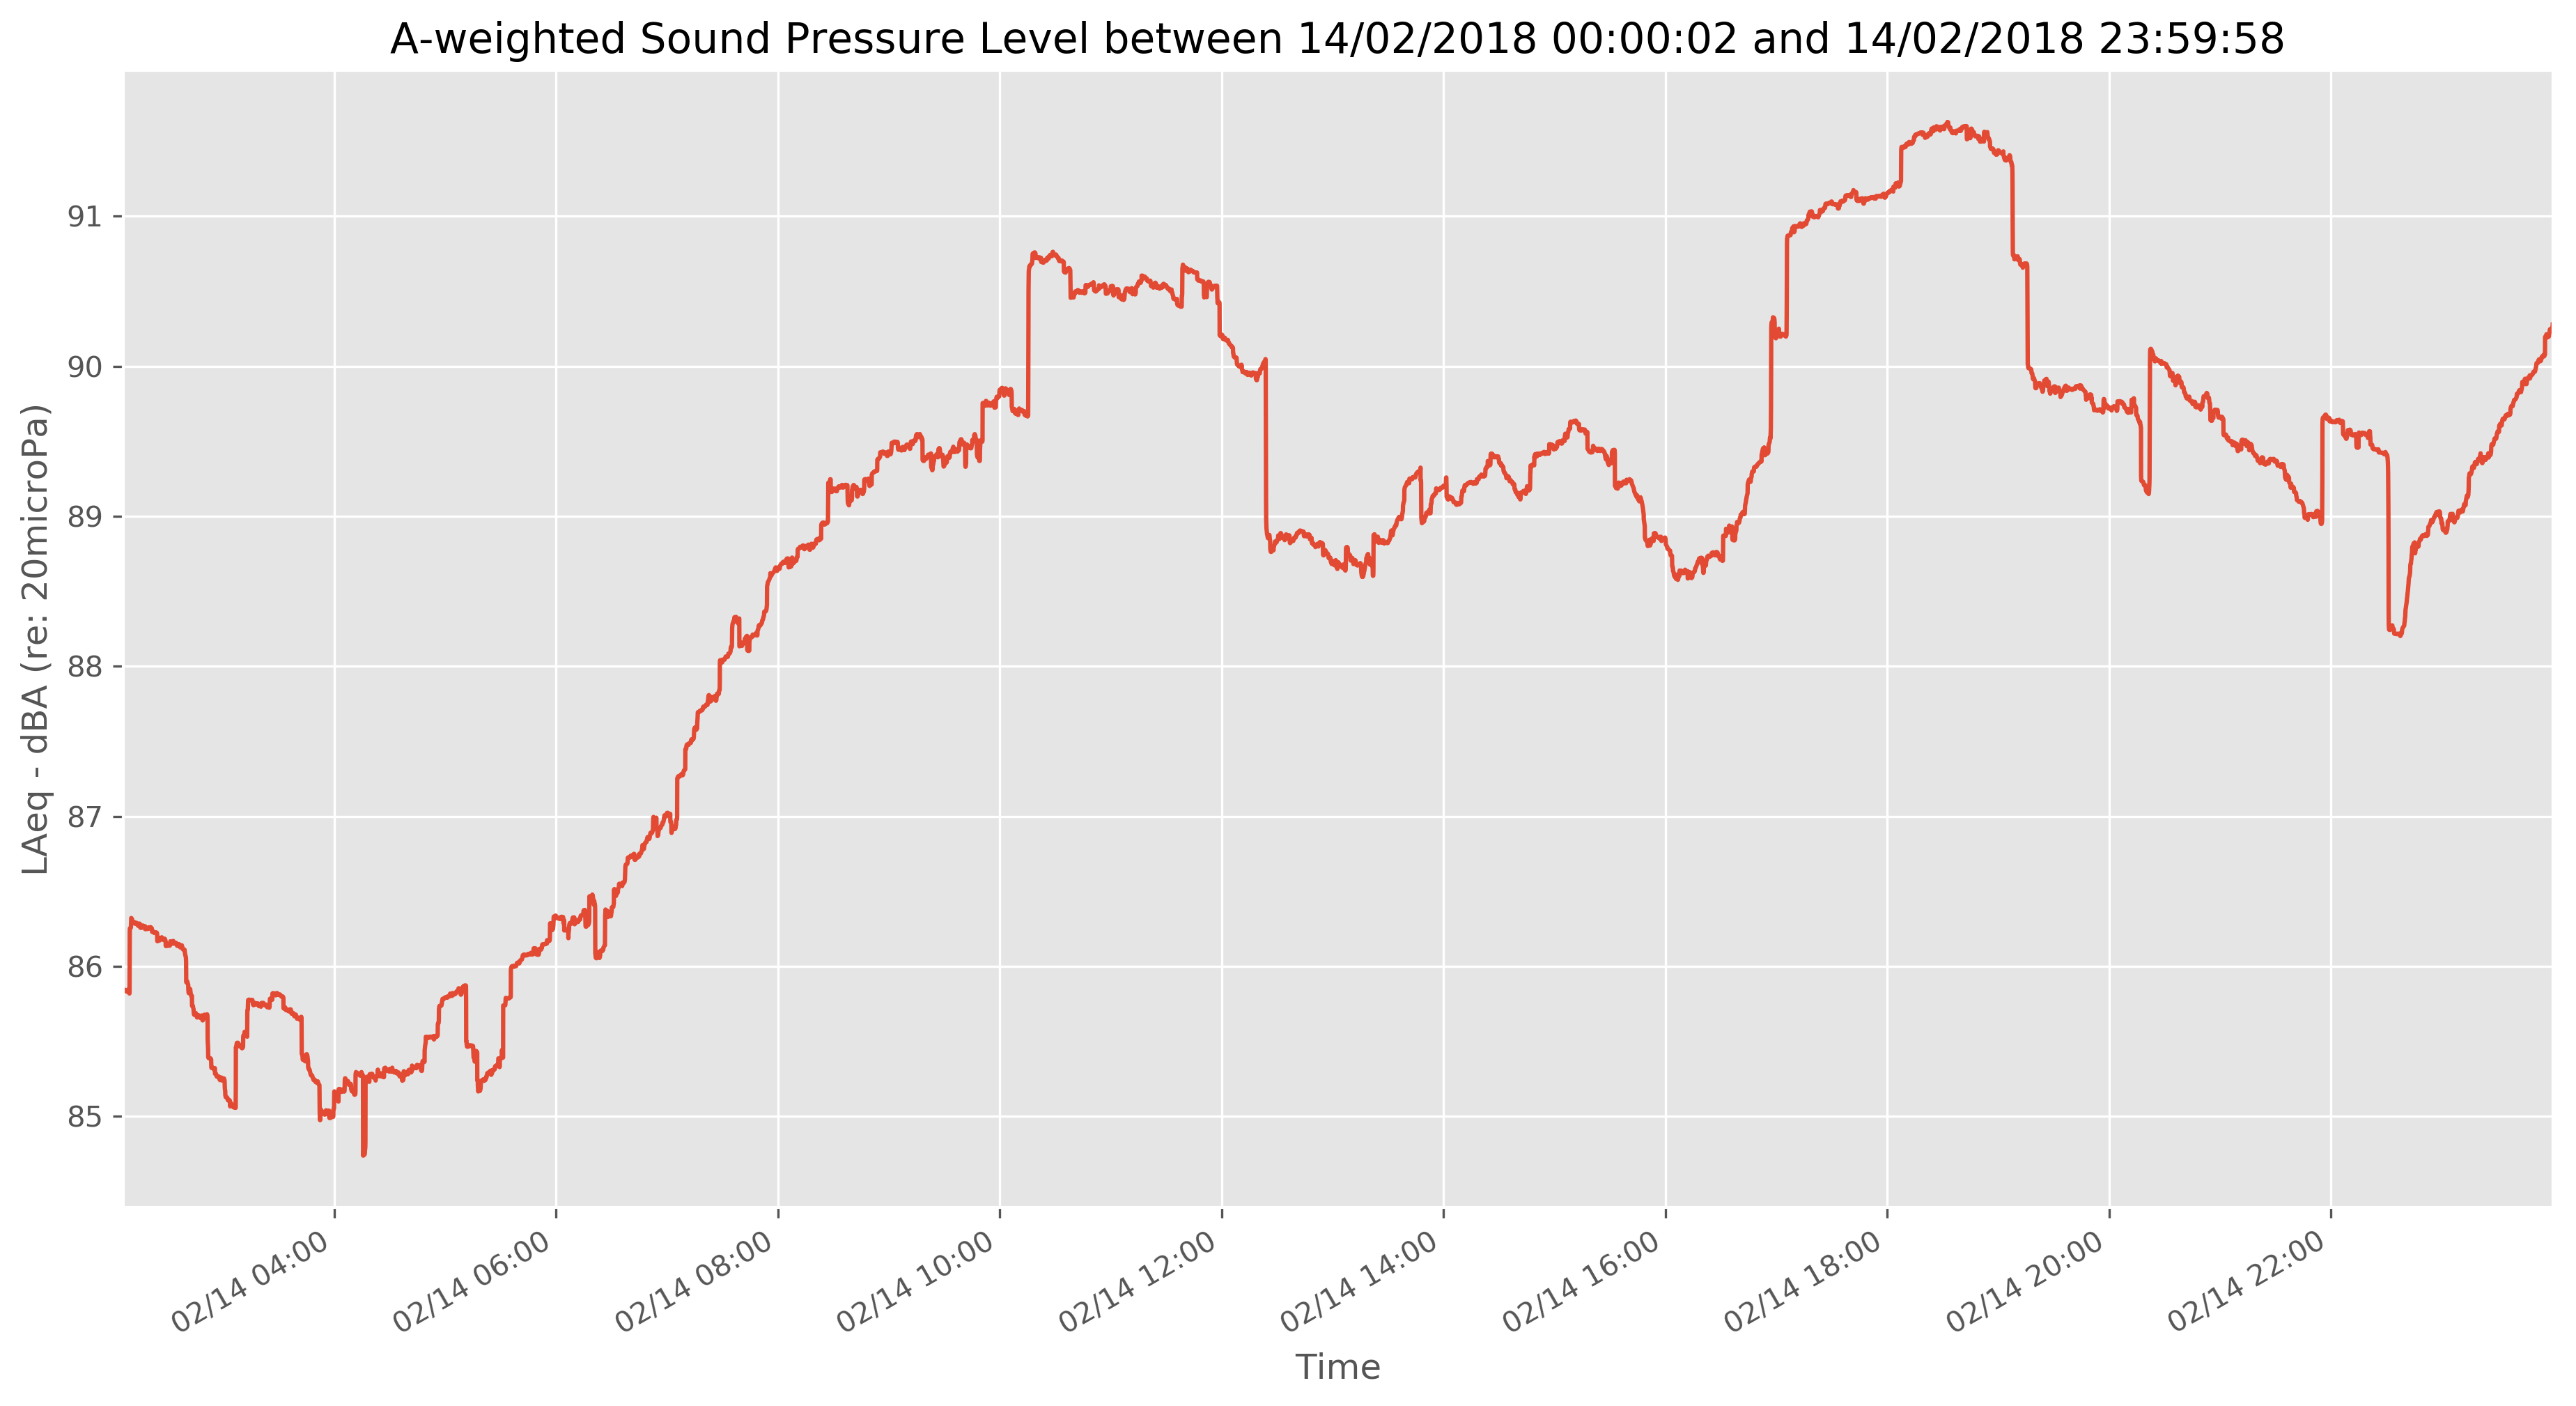

In [13]:
### You can play with this :D

average_over = 120 # minutes
###

# approx samples per minute
sample_frequency = np.mean(
    np.timedelta64(1, 'm') 
    / np.diff(df.index)
)
print('rolling average over {} minutes, ~{:.1f} samples / min'.format(
    average_over, sample_frequency
))

# compute the moving average over the LAeq data
# .apply lets you apply a custom function for a mean dB - calculates mean in the right way, w/ log
laeq_moving_avg = df.laeq.rolling(
    window=int(average_over * sample_frequency)
).apply(mean_dB).dropna()

# show the smoothed time series
laeq_moving_avg.plot()
plt.title('A-weighted Sound Pressure Level between {:%d/%m/%Y %H:%M:%S} and {:%d/%m/%Y %H:%M:%S}'.format(
    df.index.min(), df.index.max()
))
plt.xlabel('Time')
plt.ylabel('LAeq - dBA (re: 20microPa)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%m/%d %H:%M'));
print ("this makes sense for a weekday - check these trends")

## Can we find any patterns?
Here we are looking at the weekday vs. weekend patterns of noise over the course of the day. The code below first groups the data by weekday vs. weekend, then groups each of those by hour of the day and computes the average for each hour. 

In [22]:
def average_hourly_spl(df):
    # averages over the hour of the day
    return df.groupby(df.index.hour).apply(mean_dB)

# get numpy array with weekend/weekday
is_weekend = pd.Series(df_full.index.weekday <= 5).map(
    {True: 'Weekday', False: 'Weekend'}
).values

# first groupby weekday vs weekend, then groupby and average over each hour
dB_by_wk_hr = df_full.laeq.groupby(is_weekend).apply(average_hourly_spl).unstack()
dB_by_wk_hr.head()

level_time,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Weekday,88.592757,86.464719,85.848850,86.240584,87.177101,87.089775,88.750064,89.614057,89.314985,90.145525,...,89.362460,90.099607,90.761058,90.603135,90.862596,90.326576,89.654872,89.748815,89.354978,88.971622
Weekend,90.129894,87.795826,87.075499,87.458242,88.503924,86.727132,87.414620,86.239013,90.848667,87.955452,...,87.581102,86.563276,88.929213,88.591687,87.170680,86.435832,88.657552,86.546755,85.864041,84.699237


In [25]:
dB_by_wk_hr.T.plot?


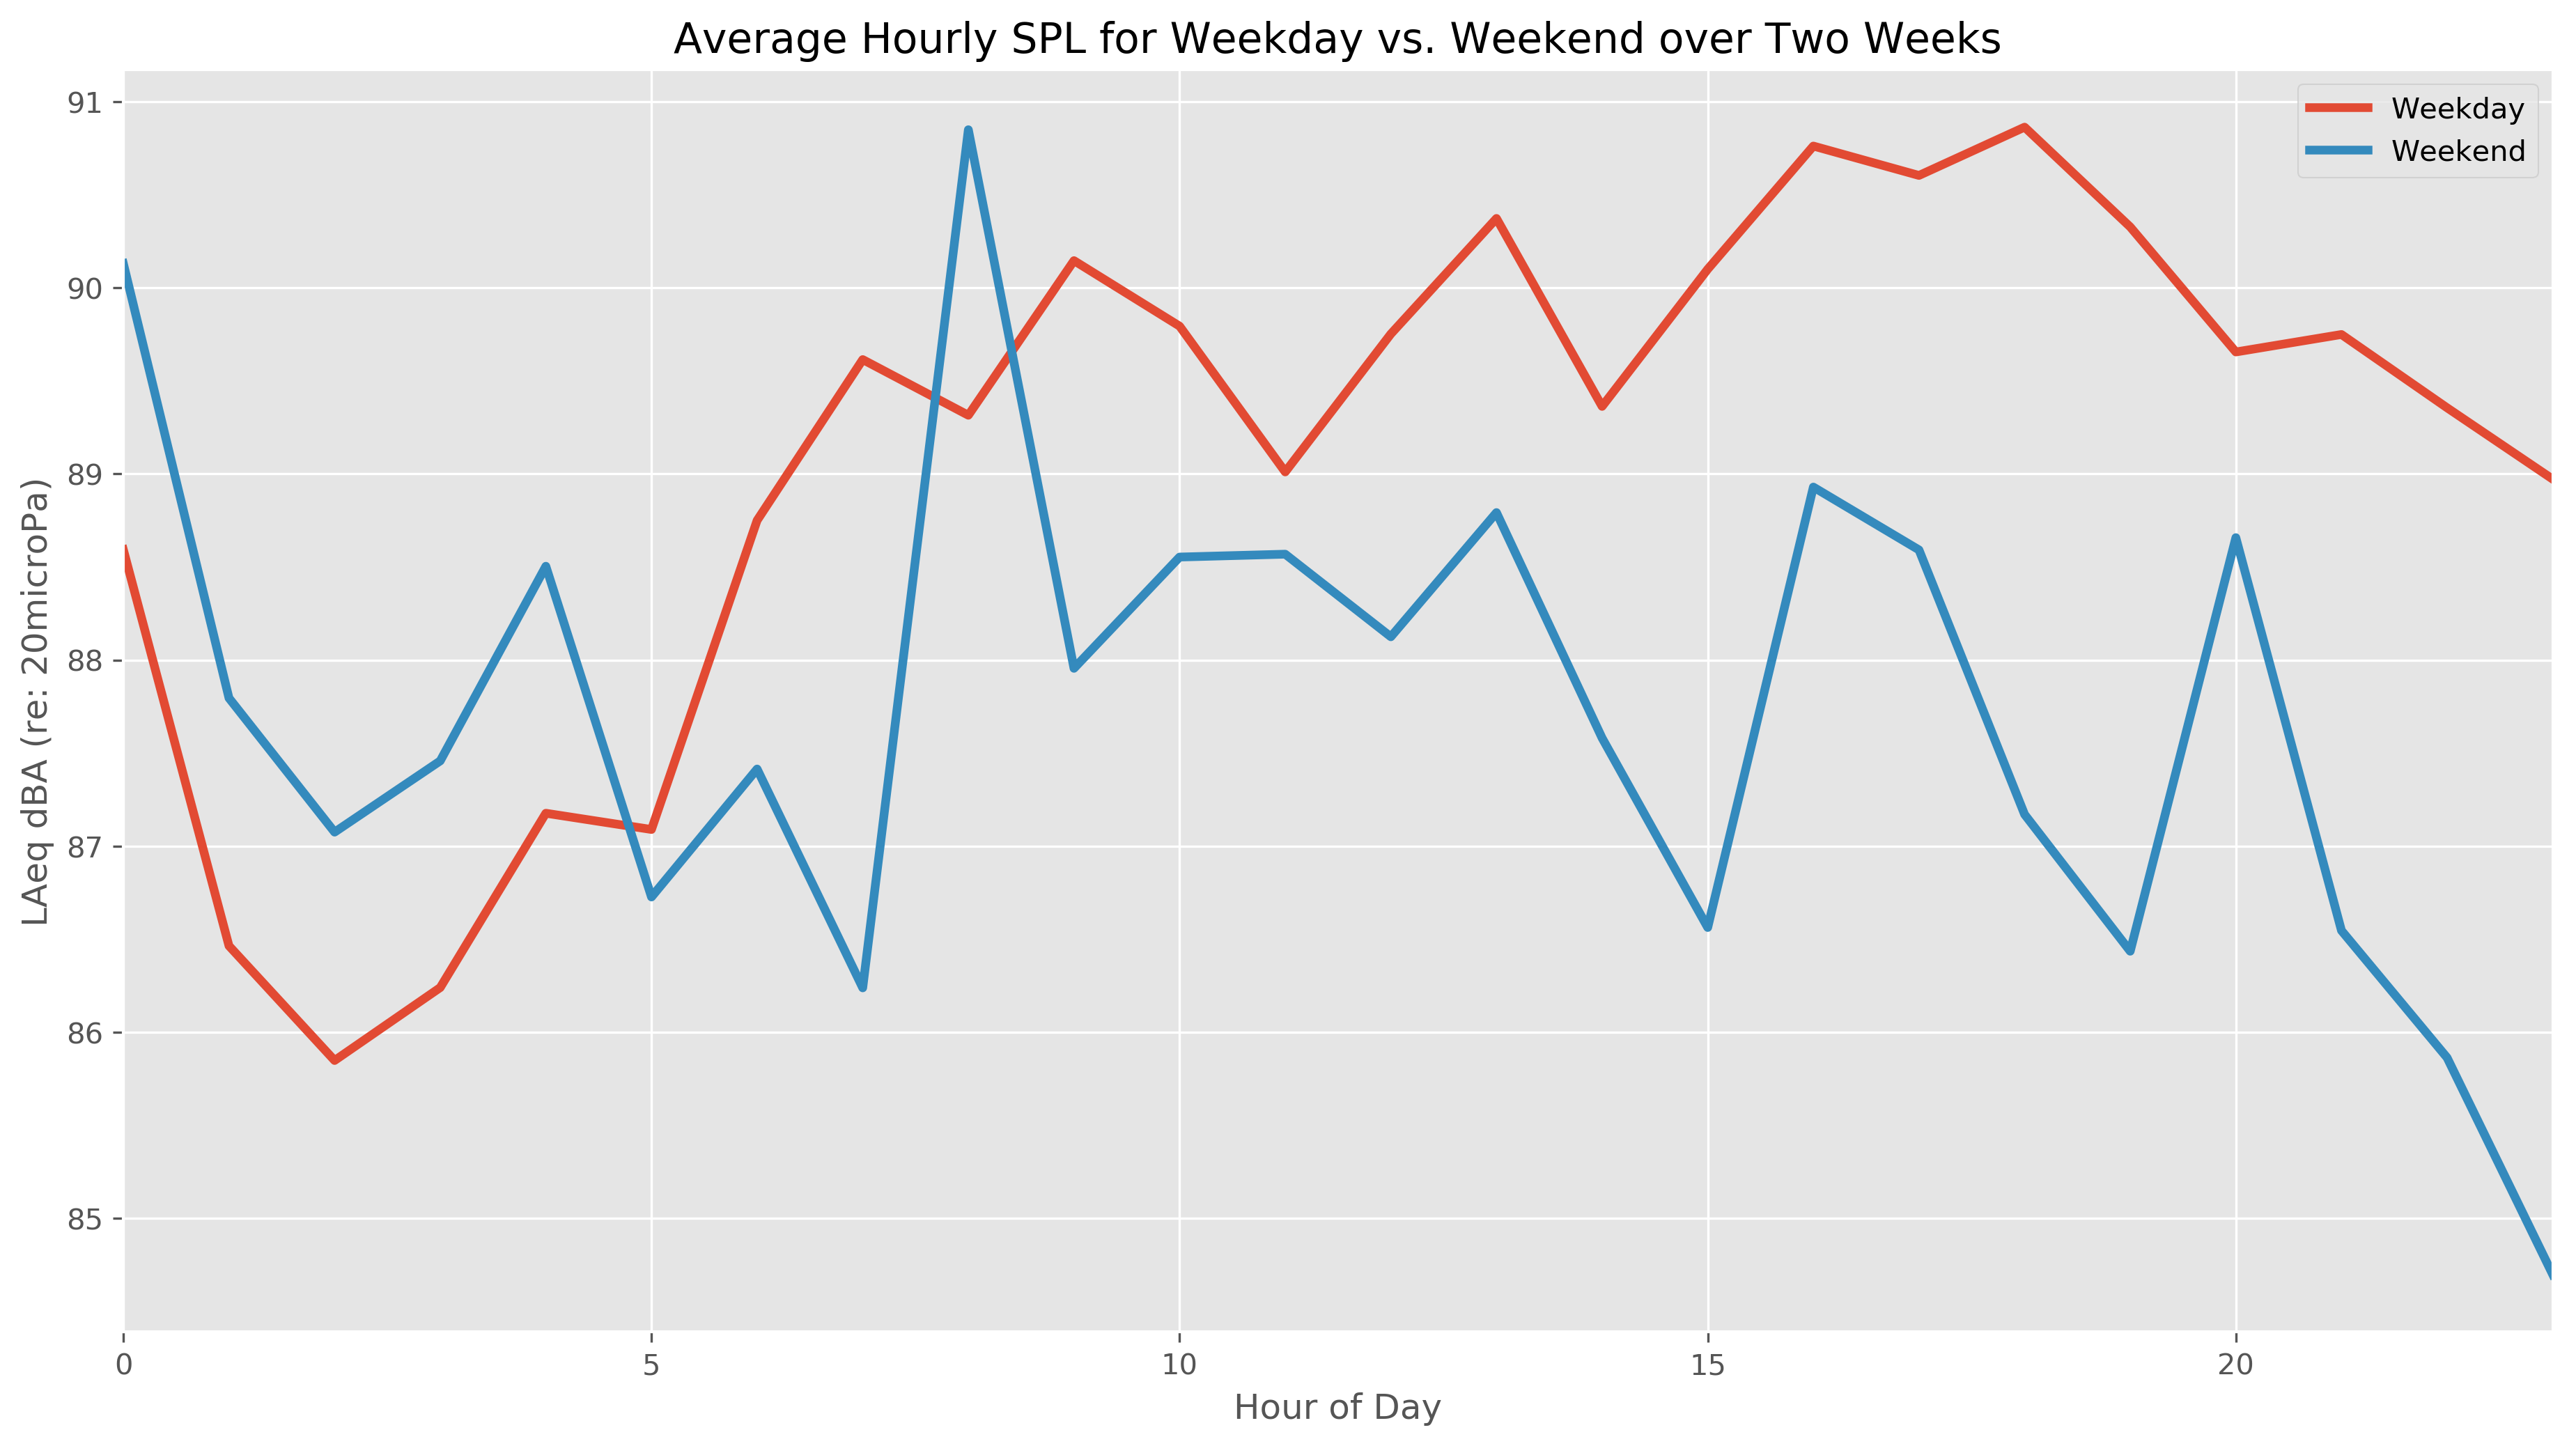

In [29]:
dB_by_wk_hr.T.plot(linewidth=3.0)
plt.title('Average Hourly SPL for Weekday vs. Weekend over Two Weeks')
plt.xlabel('Hour of Day')
plt.ylabel('LAeq dBA (re: 20microPa)');
plt.legend()
# add fouier transform to long form spl data and you don't need to worry about using dBs... 
# look for spikes over time

There appears to be a higher overall sound level throughout the day during weekdays than during the weekend. There is a marginally higher level in the mornings over the weekend, possibly caused by an abnormally noisy event on one weekend morning. This is a very cursory analysis of the data, however it demonstrates the types of aggregations that you can perform to detect recurrent patterns in your data.

## Event Detection
One frequent use of sound pressure level data is to find anamolous behavior, for example identifying unlawful construction. The most simple method of doing this is to just define a threshold and report whenever the level exceeds that threshold.

In [31]:
## this isn't running on python 3. it will run fine on python 2.



### set your own threshold based on what events you want to catch
threshold = 90
###

# get the degree of an event
laeq_moving_avg.plot()

# check against threshold
is_event = laeq_moving_avg >= threshold

# draw threshold line
plt.plot([laeq_moving_avg.index.min(), laeq_moving_avg.index.max()], [threshold]*2)

# draw the colored points
plt.scatter(
    laeq_moving_avg.index, laeq_moving_avg, 
    c=is_event.astype(int), 
    cmap=plt.cm.jet, s=10, zorder=10, linewidth='0')

plt.gca().get_lines()[0].set_color("black")

plt.title('Event Detection with Manual Thresholding')
plt.xlabel('Time')
plt.ylabel('LAeq - dBA (re: 20microPa)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%m/%d %H:%M'));

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

But this involves physically setting the threshold to a value that is going to be meaningful. And if you're managing a large array of sensors, they may have different ambient levels and you may want a more adaptive threshold. 

A basic method of adaptive thresholding is by using normalization, where we transform the data into the distance that that point is from the mean, in units of standard deviations (meaning a value of 1 signifies that it is one standard deviation away from the mean).

using a threshold of: 90.6


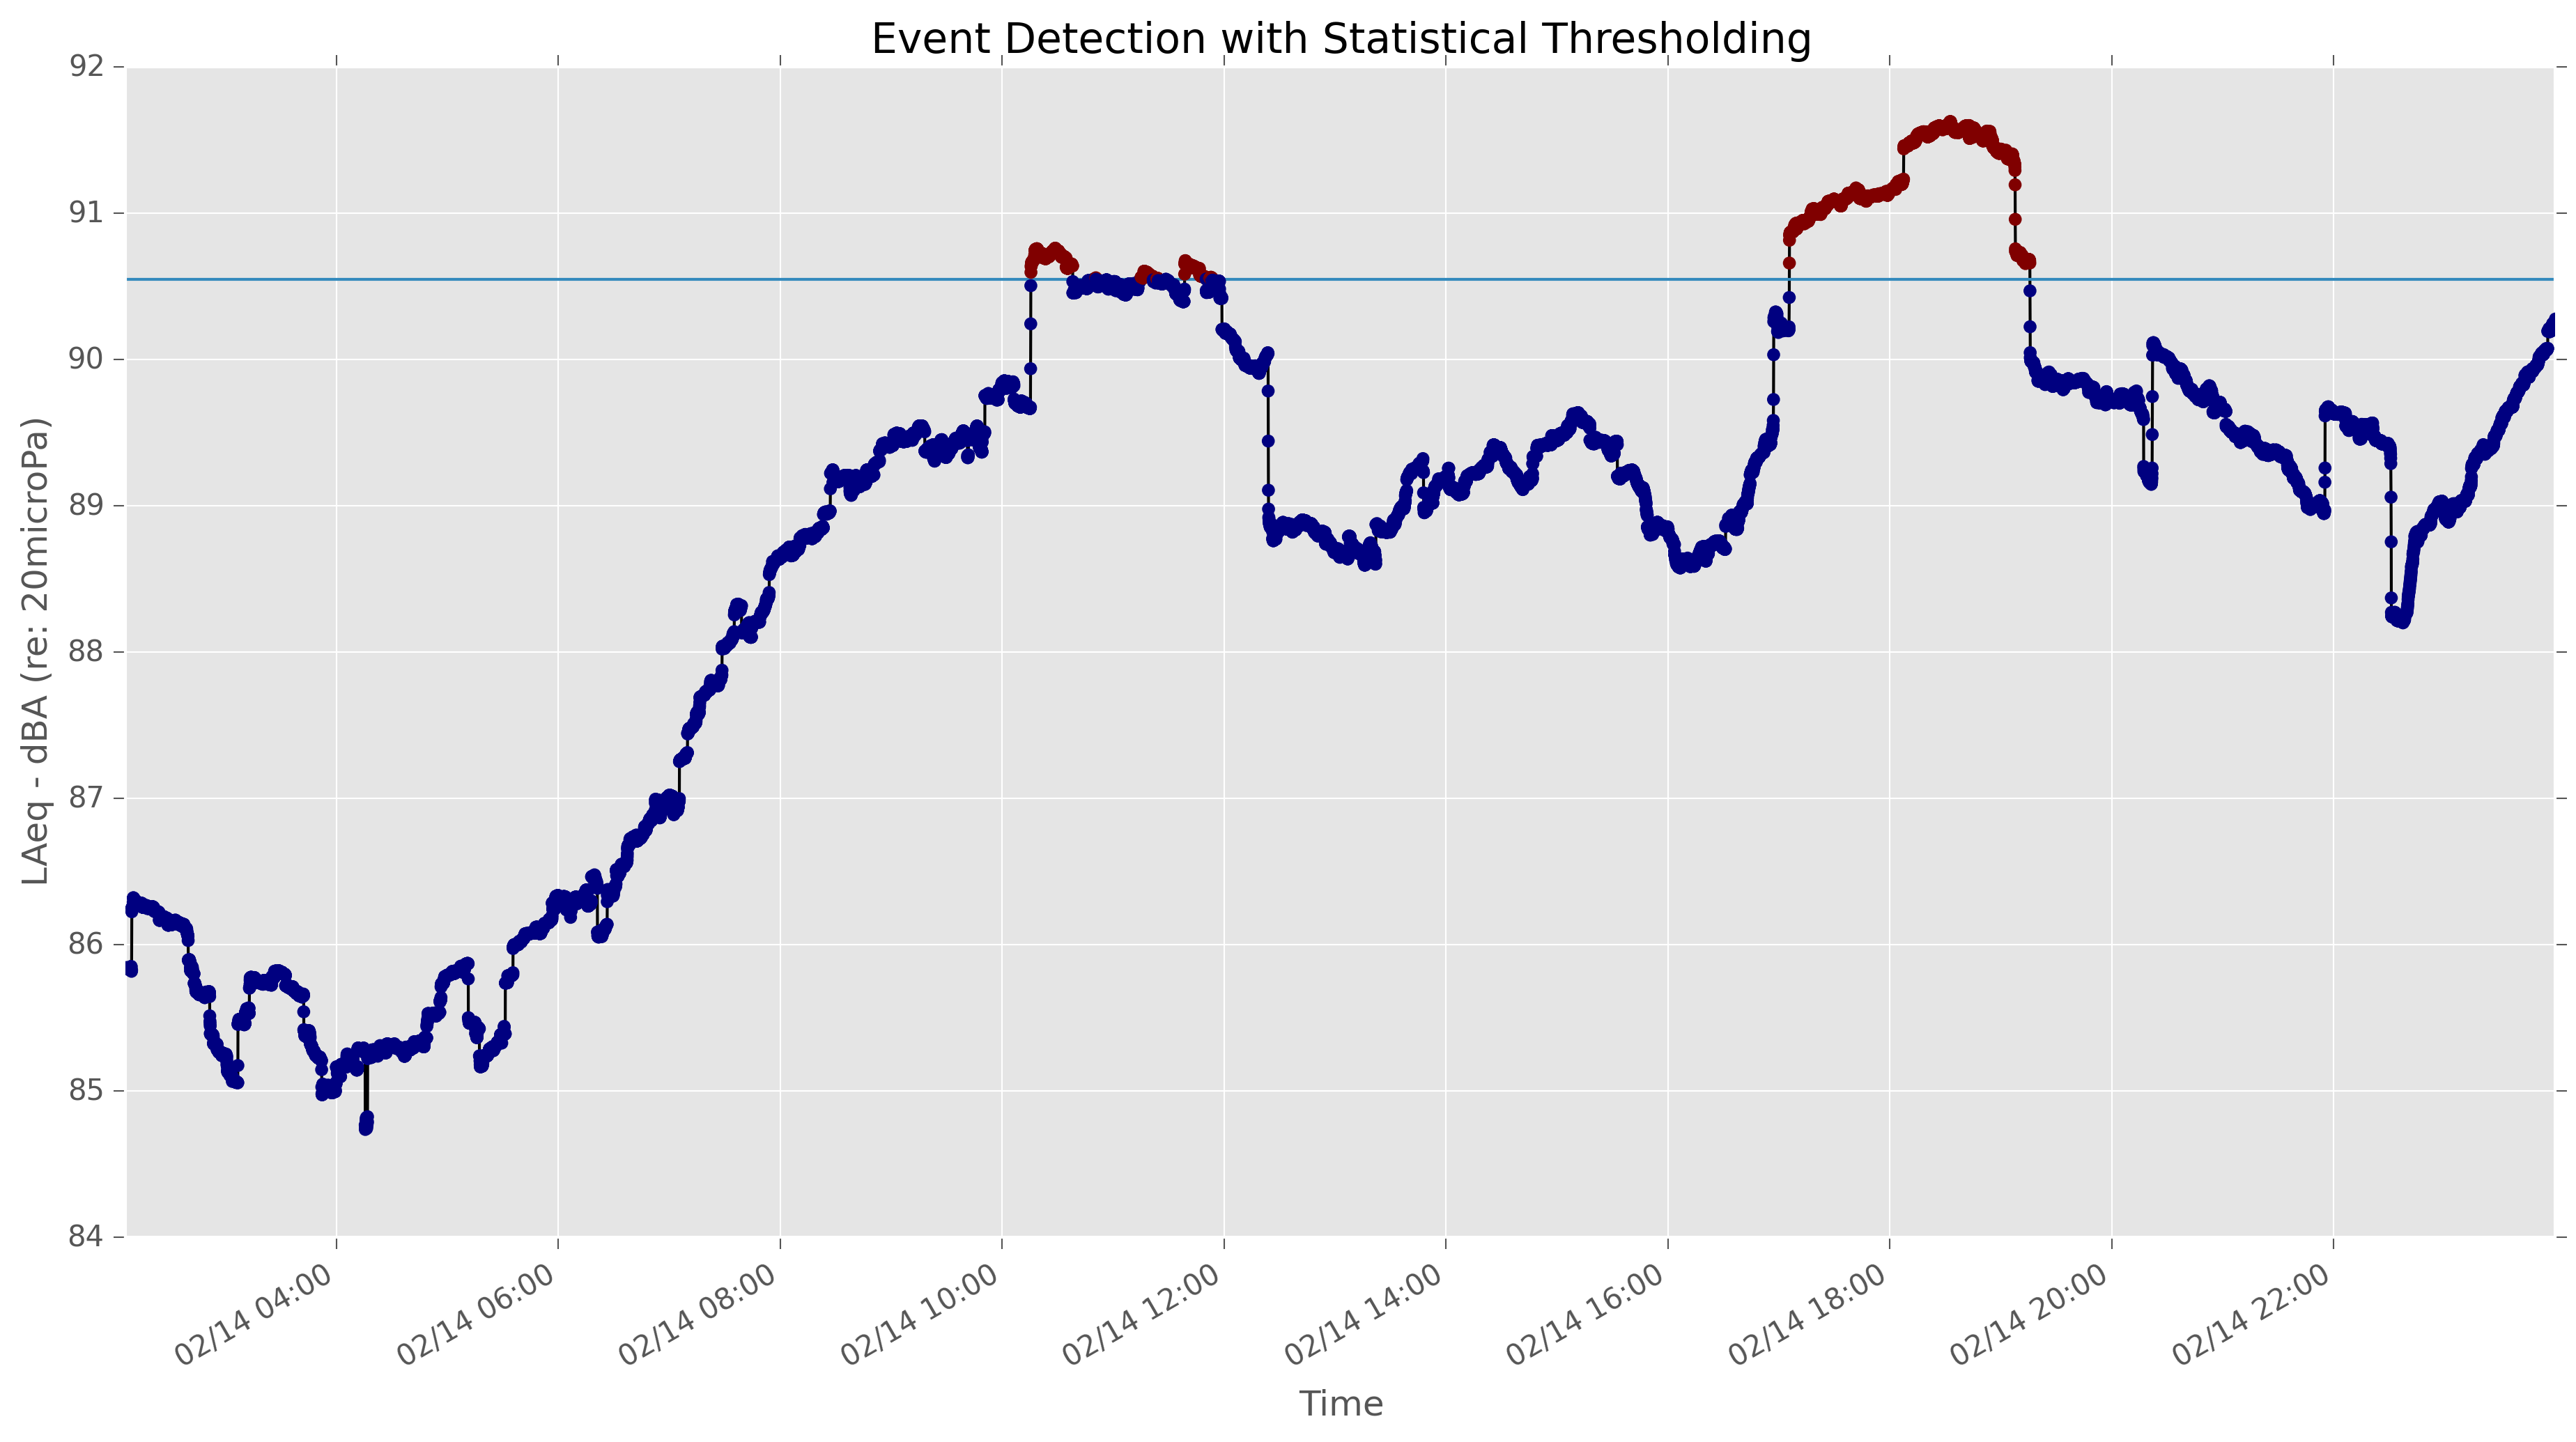

In [11]:
### you can tweak this if you're so inclined
n_standard_deviations = 1
###

def normalize(x):
    '''Get the # standard deviations from the mean'''
    return (np.array(x) - np.nanmean(x)) / np.std(x)

# scales all data based on the mean and standard deviation
laeq_norm = normalize(laeq_moving_avg)

laeq_moving_avg.plot()

# draw threshold line
threshold = laeq_moving_avg.mean() + n_standard_deviations * laeq_moving_avg.std()
print('using a threshold of: {:.1f}'.format(threshold))
plt.plot([laeq_moving_avg.index.min(), laeq_moving_avg.index.max()], [threshold]*2)

# checks values against threshold, can use negative value for lower bound
is_event = (laeq_norm >= n_standard_deviations if n_standard_deviations > 0 
       else laeq_norm <= n_standard_deviations)

# draw the colored points
plt.scatter(
    laeq_moving_avg.index, laeq_moving_avg,
    c=(is_event).astype(int),
    cmap=plt.cm.jet, zorder=10, linewidth='0')

plt.gca().get_lines()[0].set_color("black")

plt.title('Event Detection with Statistical Thresholding')
plt.xlabel('Time')
plt.ylabel('LAeq - dBA (re: 20microPa)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%m/%d %H:%M'));

## Real-Time Event Detection
Now we're going to do some event detection using your own microphone input :D. You'll need to install pyaudio if you don't have it installed already. You should have ipywidgets installed with Jupyter by default, but I'm sorry if you have any trouble '_'

In [39]:
!pip install pyaudio
# Or
# !conda install jupyter_core notebook nbconvert ipykernel ipywidgets

/bin/sh: pip: command not found


In [34]:
import pyaudio
from datetime import datetime
audio = pyaudio.PyAudio()
stream = None

from IPython.display import display
from ipywidgets import widgets as w

ModuleNotFoundError: No module named 'pyaudio'

### Setting up the widgets
You don't really need to worry about what's going on here so you can **skip over it**. Here we are creating the start/stop buttons, the text output, and the threshold slider.

In [14]:
# create buttons to start and stop recording    
start_stop = w.ToggleButtons(
    options=['Start', 'Stop'],
    description='Listening:',
    value='Stop',
)

# create a function to call when a button is pressed
def start_stop_recording(b):
    global stream
    # check the new button value
    if b['new'] == 'Start':
        stream.start_stream()
    else: 
        stream.stop_stream()
        print('Stopped!')

start_stop.observe(start_stop_recording, 'value')


# create a label to print and update text
label = w.Label()


# create an input to change the threshold
threshold_slider = w.FloatSlider(
    value=90, # default value
    min=0, max=150, # slider bounds
    step=0.1,
    description='Threshold:',
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

### Initializing the audio stream
Again, you can **just keep moving**. This sets up the audio recording and converts the raw audio stream into instantaneous sound pressure levels.

In [15]:
calls_per_second = 10 # the number of times the function is called per second
MAX_dB = 110 # the max SPL that the microphone can pick up (I arbitrarily picked this fyi)

# calculates the maximum SPL representable by your computer for full-scale normalization
REF_dBFS = 20*np.log10(np.iinfo(np.int16).max)

def to_dB(samples, ref_dB=0):
    '''Convert array of samples to the average decibel level
    Arguments:
        samples (np.array): audio amplitude
        ref_dB (float): the reference dB level
    '''
    return 10*np.log10( np.mean(samples**2.) ) - ref_dB

# define callback to be called on every buffer update
def pyaudio_callback(in_data, frame_count, time_info, status):
    # convert from bytestring to array
    audio_data = np.fromstring(in_data, dtype=np.int16)
    
    # convert from raw audio to LAeq
    spl = to_dB(audio_data, ref_dB=REF_dBFS - MAX_dB)
    
    try:
        keep_going = process_spl(spl) # this is for you to define later
    except Exception, e:
        keep_going = False
        print('Error: {}'.format(e))
    
    # fyi, you can return false from process_laeq to stop recording
    status = pyaudio.paContinue if keep_going is not False else pyaudio.paComplete
    return (in_data, status)

# if we're rerunning this cell, close previous stream object
if stream and stream.is_active():
    stream.stop_stream()
    stream.close()

# setting up audio stream to use callback function
Fs = 44100 # audio sample rate (frames/sec)
stream = audio.open(format=pyaudio.paInt16,
                channels=1, # just use mono
                rate=int(Fs), # fps
                frames_per_buffer=int(1.*Fs / calls_per_second), # number of samples it serves at a time
                input=True, # tell pyaudio that we want mic input
                start=False, # don't want it to start right away
                stream_callback=pyaudio_callback)

### Detect some events!
Now here's the juicy part. The function `process_laeq` is called everytime new data comes in. The function above processes the audio data, converts it into dB, and then passes it to you in the function below. Now you can do whatever you want with the live sound level data coming in :). I've added some basic code that prints out when the level exceeds the threshold defined by the slider, but feel free to tweak whatever. That's what cmd-Z is for.

Some examples of things you could do are:
* **averaging**. You could collect a buffer of previous $L_{Aeq}$ values and check the threshold over the average over that buffer. This would remove more sporatic behavior, for example if you had a noisy mic. I'd recommend using `collections.deque` which make it easy to work with fixed length arrays.
* **plotting**. You could plot a moving window of the $L_{Aeq}$. Real-time matplotlib plotting is a bit tricky, but one thing you'll have to do is change `%matplotlib inline` to `%matplotlib interactive` at the top of the notebook.
* **"smart" alerts**. If you notice, the function fires an alert every single time the level exceeds the threshold. So if you were to scream into your microphone for a few seconds (NO SHAME), you'd notice that a long string of alerts would start to print out. Now if this was alerting me via slack or email, I'd be pretty ticked. So you could develop something that tracks whether the system is in an *alerted* state and only issues alerts when there is a new event. 
* **adaptive thresholding**. You could apply the technique of adaptive thresholding using normalized $L_{Aeq}$ values over a fixed window of past SPL values
* Whatever other brilliant things you can think of

**Hint**: Some easy ways to trigger events are by snapping, clapping, or tapping the microphone. Or you can just make mouth sounds. You do you.

**Note**: These levels are totally **uncalibrated!!** So don't try and take the data that you get here to the DEP or whatever. 

In [16]:
def process_spl(laeq):
    '''Do whatever you want in here! This is called everytime the LAeq is computed.
    Arguments:
        laeq (float): the uncalibrated sound level (dB) at that specific moment.
    '''
    
    # this function is your oyster :D
    
    # print out events
    is_event = 'no event :('
    if laeq > threshold_slider.value:
        print('event! LAeq={:.2f}, Occurred at {:%H:%M:%S}'.format(laeq, datetime.now()))
        is_event = 'event! :D'
    
    # put live-updating info inside the label widget so it doesn't print on new lines and make you cry
    label.value = '{:.2f}dB - {}'.format(laeq, is_event)
    
# reset the button state
start_stop.value = 'Start' if stream.is_active() else 'Stop'
display(w.HBox([start_stop, threshold_slider]))
display(label)

HBox(children=(ToggleButtons(description=u'Listening:', index=1, options=('Start', 'Stop'), value='Stop'), FloatSlider(value=90.0, description=u'Threshold:', max=150.0, readout_format=u'.1f')))

Label(value=u'')

In [17]:
# stream.stop_stream() # in case things start acting up :D
# stream.close()
# # if things start freezing (cell stuck on [*]) you might need to restart the kernel
# # if things start printing out like crazy and you can't stop them, you should probs just restart the kernel